## 흩어진 csv 파일 통합

In [1]:
import os
import pandas as pd
dirs = ["셀트리온"]
for dir in dirs:
    total_df = pd.DataFrame(None, columns=["stock_name","date","title","content"])

    for f in os.listdir(os.path.join("종토방", dir)):
        if not f.endswith(".csv"): continue
        try:
            read = pd.read_csv(f"종토방/{dir}/{f}", index_col=0, encoding="cp949")
        #인코딩 문제가 있다면?
        #if not all(read.stock_name==dir):
        except UnicodeDecodeError:
            read = pd.read_csv(f"종토방/{dir}/{f}", index_col=0, encoding="utf8")

        total_df = pd.concat([total_df, read])
        
    total_df = total_df.sort_index()
    total_df.date = pd.to_datetime(total_df.date)
    total_df = total_df.drop_duplicates(['title','content'])
    df_from = min(total_df.date)
    df_to = max(total_df.date)
    total_df.to_csv(f"종토방/{dir}/{dir} {df_from.year}-{df_from.month}-{df_from.day} to {df_to.year}-{df_to.month}-{df_to.day}.csv")
    print(total_df.stock_name.unique(), min(total_df.date), max(total_df.date))


[nan '셀트리온'] NaT NaT


## pretrained LSTM 모델을 활용하여 평가

In [1]:
import pandas as pd

def read_dir(path):
    total_df = pd.DataFrame(None, columns=["stock_name","date","title","content"])
    for f in os.listdir(os.path.join("종토방", path)):
        if not f.endswith(".csv"): continue
        try:
            read = pd.read_csv(f"종토방/{path}/{f}", index_col=0, encoding="cp949")
        #인코딩 문제가 있다면?
        #if not all(read.stock_name==dir):
        except UnicodeDecodeError:
            read = pd.read_csv(f"종토방/{path}/{f}", index_col=0, encoding="utf8")

        total_df = pd.concat([total_df, read])
    total_df = total_df.sort_index()
    total_df.dropna(inplace=True)
    total_df = total_df.drop_duplicates(['title','content'])
    return total_df

In [2]:
import pickle
from konlpy.tag import Okt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()
sent_model = load_model('pretrained_lstm_감정분석모델/best_model.h5')
with open("pretrained_lstm_감정분석모델/tokenizer.pickle", "rb") as handle:
    sent_tokenizer = pickle.load(handle)
def sentiment_predict(new_sentence):
  
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = sent_tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 30) # 패딩
    score = float(sent_model.predict(pad_new)) # 예측

    return round(score, 4)

In [3]:
df = read_dir("현대제철")
raw = df.copy()
df

,stock_name,date,title,content
0,현대제철,2021-05-13,현대제철 고민이 되면..,"현대제철,...::\rhttps://bit.ly/3w3fAON\r 시외장부터 내일 ..."
0,현대제철,2021-05-14,상속세 때문에,누른다는 얘기가 맞으려연 포스코는 왜 내리나?\r지난달49500까지 오른후 370...
0,현대제철,2021-5-22,월요일 무조건 5만 지지선 이탈,"철강쪽 가수요 및 투자자들\r반도체, 자동차, 2차전지로 이동 가속화.\r게다가 원..."
0,현대제철,2021-5-17,현철 to the moon~!!!,With doge and POSCO^^
0,현대제철,2017-12-30,현대제철 공장 폭팔,전기문제로...
...,...,...,...,...
34118,현대제철,2017-10-30,호실적이하더니,패대기치기바쁘네 ㅋ
34119,현대제철,2017-10-30,짱돌에,대가리 맞았군요
34120,현대제철,2017-10-30,노가리고수,현구간...금일고점..중간마디숫자 8인..58200고점찍었네요.....이히히히히.....
34121,현대제철,2017-10-30,오늘도 부탁해~~,훨훨 날자~~


In [4]:
def make_label(row: pd.Series):
    return sentiment_predict(row.title + ". " + row.content)

df["label"] = df.apply(make_label, axis=1)
df

## LSTM모델 직접 훈련

In [36]:
#데이터 load
import os
import pandas as pd

train_dir = "감성분석_학습용데이터"
train=pd.DataFrame()
#이진분류 여부
binary=True
#True시 긍부정모델, False시 뻘글분류모델
binary2=True
SEQ_LEN=32


if binary:#이진분류시
    classes = (1, "sigmoid", "binary_crossentropy", "accuracy")
else:#삼진분류시
    classes = (3, "softmax", "categorical_crossentropy", "categorical_accuracy")

for f in os.listdir(train_dir):
    
    if f.endswith(".csv"):
        temp = pd.read_csv(os.path.join(train_dir, f), encoding="cp949")
        temp["document"] = temp["title"] + "\r" + temp["content"]

        #이진분류냐 삼진뷴류냐에 따라 다르게 적용
        if binary:
            #이진분류시 적용
            if binary2:
                temp = temp[(temp["label"].notnull()) & (temp["label"].isin([0.,2.]))]
                temp["label"] = temp["label"].apply(lambda x: 1 if x==2 else 0)
            else:
                temp = temp[(temp["label"].notnull()) & (temp["label"].isin([0.,1.,2.]))]
                temp["label"] = temp["label"].apply(lambda x: 0 if x==2 or x==0 else 1)

        else:
            temp = temp[(temp["label"].notnull()) & (temp["label"].isin([0.,2., 1.]))]
    elif f.endswith(".txt"):
        temp = pd.read_csv("감성분석_학습용데이터\\ratings.txt", encoding="cp949")

    train = pd.concat([train, temp])
train = train.drop(["title", "content"], axis=1)
train = train[train.document.notnull()]
train["stock_name"].fillna("0", inplace=True)
print(train.label.value_counts())
print("total records:",len(train.label))
train

0    4580
1    4353
Name: label, dtype: int64
total records: 8933


,label,stock_name,date,Unnamed: 5,Unnamed: 6,document,Unnamed: 1
0,0,CJ제일제당,2020-07-15,NaN,NaN,올라가면 한방씩 쏘냐 ㅠㅠ\r올라가기 힘드네요,NaN
1,0,CJ제일제당,2017-12-20,NaN,NaN,본격 하락세 시작이라고 경고해따\r지금은 팔때이지 \r 매수할때가 아님,NaN
2,0,CJ제일제당,2020-02-24,NaN,NaN,수출 비중이 높은 식음료업체는 악재...\r수출/생산이 어떻게 될지 모르는 ㅠ,NaN
3,0,CJ제일제당,2019-02-15,NaN,NaN,정말 이렇게 길게 횡보하는 주식은 처음 보내요.\r횡보가 길면 추세도 길다고 하지만...,NaN
4,0,CJ제일제당,2020-02-28,NaN,NaN,일본인들은 30년 전부터~ 모든 수익성자산에 투자하지 않는다. 집도 잘 사지 않는다...,NaN
...,...,...,...,...,...,...,...
1466,0,호텔신라,2020-10-19,NaN,NaN,오르다가\r또떨어지겠지,7979.0
1474,1,호텔신라,2020-10-18,NaN,NaN,낼 큰폭오를것\r 기대해본다\r 제자리만 있을것이 못된다\r 내일은 적어도13퍼는...,7987.0
1492,1,호텔신라,2020-10-17,NaN,NaN,중국 일반인 백신접종 시작!!!\r중국 일반인 백신접종 시작\r(브라질 3상 종료 ...,8005.0
1494,1,호텔신라,2020-10-17,NaN,NaN,백신 접종 시작되고\r입국제한 풀리면 전세계인들의 보복소비 러쉬가 일어날꺼다 면세주...,8007.0


In [37]:
import codecs
import keras.applications, keras.datasets, keras.preprocessing, keras.wrappers
from keras_bert import Tokenizer

pretrained_path ="bert_eojeol_tensorflow"
vocab_path = os.path.join(pretrained_path, 'vocab.korean.rawtext.list')
token_dict = {}

with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip().split('\t')[0]
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

tokenizer = inherit_Tokenizer(token_dict)

In [38]:
from tqdm import tqdm
import numpy as np
import re

def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        raw = data.iloc[i]
        
        #데이터 클렌징
        pattern1 = re.compile("\(.+?\)") #괄호 제거
        pattern2 = re.compile("[^(ㄱ-ㅎ가-힣a-zA-Z \?\r\.,)]")#특수문자 및 숫자 제거
        cleaned = pattern1.sub("", raw)
        cleaned = pattern2.sub("", cleaned)

        ids, segments = tokenizer.encode(cleaned, max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return indices

def sentence_load_data(sentences):#sentence는 List로 받는다

    data_x = sentence_convert_data(sentences)

    return data_x

In [39]:
#데이터 프로세싱 1차
from sklearn.model_selection import train_test_split
from keras.utils.all_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(train[["document", "stock_name"]], train[["label","stock_name"]], test_size=0.2, random_state=2, stratify=train["stock_name"])
X_train = X_train["document"]
X_test = X_test.document[X_test.stock_name != "0"]
y_train = y_train.label
y_test = y_test.label[y_test.stock_name != "0"]
X_train = sentence_load_data(X_train)
X_test = sentence_load_data(X_test)


if not binary:
    y_train = to_categorical(y_train, num_classes=classes[0])
    y_test = to_categorical(y_test, num_classes=classes[0])

100%|██████████| 1787/1787 [00:00<00:00, 3462.88it/s]


In [40]:
import keras
from keras import layers

model = keras.Sequential()
model.add(layers.Embedding(len(token_dict), 128, input_length=SEQ_LEN)) #입력층
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(128)) #은닉층
model.add(layers.Dropout(0.4))
#model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(classes[0], activation=classes[1]))
model.compile(loss=classes[2], metrics=[classes[3]], optimizer='adam')
model.summary()
history = model.fit(X_train, y_train, batch_size=128, epochs=4, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 128)           3942272   
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 4,073,985
Trainable params: 4,073,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
45/45 [==============================] - 4s 41ms/step - loss: 0.6905 - accuracy: 0.5281 - val_loss: 

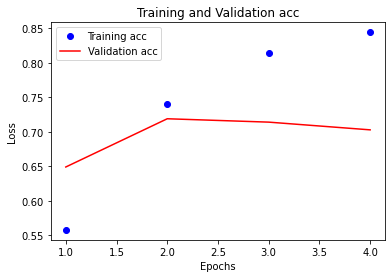

In [41]:
import matplotlib.pyplot as plt
acc = history.history[classes[3]]
val_acc = history.history["val_"+classes[3]]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and Validation acc")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [42]:
from sklearn.metrics import accuracy_score, f1_score
def test(array):
    returnArray = np.zeros_like(array)
    for idx, element in enumerate(array):
        if binary:
            if element > 0.5:
                returnArray[idx] = 1
            else:
                returnArray[idx] = 0
        else:
            if element[0] > element[1]:
                returnArray[idx][0] = 1
            else: 
                returnArray[idx][1] = 1
    
    return returnArray

y_pred = test(model.predict(X_test))
print("정확도",accuracy_score(y_pred, y_test).round(4))
print("f1",f1_score(y_pred, y_test).round(4))

정확도 0.728
f1 0.7445


In [43]:
train.document

0                               올라가면 한방씩 쏘냐 ㅠㅠ\r올라가기 힘드네요
1                 본격 하락세 시작이라고 경고해따\r지금은 팔때이지 \r 매수할때가 아님
2             수출 비중이 높은 식음료업체는 악재...\r수출/생산이 어떻게 될지 모르는 ㅠ
3       정말 이렇게 길게 횡보하는 주식은 처음 보내요.\r횡보가 길면 추세도 길다고 하지만...
4       일본인들은 30년 전부터~ 모든 수익성자산에 투자하지 않는다. 집도 잘 사지 않는다...
                              ...                        
1466                                         오르다가\r또떨어지겠지
1474    낼 큰폭오를것\r 기대해본다\r  제자리만 있을것이 못된다\r 내일은 적어도13퍼는...
1492    중국 일반인 백신접종 시작!!!\r중국 일반인 백신접종 시작\r(브라질 3상 종료 ...
1494    백신 접종 시작되고\r입국제한 풀리면 전세계인들의 보복소비 러쉬가 일어날꺼다 면세주...
1495    치밀한놈\r월봉으로 봐도  하방 마지막 \r5파동 입니다\r이제 상승(우상향)만\r...
Name: document, Length: 8933, dtype: object

In [8]:
model.save("종토방_긍부정모델/종토방_긍부정모델.h5")